# Spectroscopy Function Tests

This notebook provides extensive testing for all functions within the spectroscopy module, ensuring they handle various scenarios correctly and identifying areas for improvement.

### **Core Functions Tested:**
Inhomogenity:
- `normalized_gauss(detunings, FWHM_val)` - Normalized Gaussian distribution for inhomogeneous broadening
- `sample_from_sigma(n_samples, FWHM_val, max_detuning)` - Rejection sampling from Gaussian distribution

Spolvers:
- `check_the_solver(rho)` - Density matrix validation (Hermitian, positive semidefinite, unit trace)

1D Data:
- `compute_1d_polarization` - 1D fixed tau_coh, T_wait:

2D Spectroscopy:
- `get_tau_cohs_and_t_dets_for_T_wait(T_wait, dt, tau_coh_max, t_det_max)` - Time array generation
- `compute_2d_polarization(tau_cohs, t_dets, T_wait, pulse_sequence, params)`

Post Processing:
- `compute_2d_fft_wavenumber(t_dets, tau_cohs, data)` - 2D spectra computation
- `extend_and_plot(...)`
---
**Last Updated:** May 30, 2025

In [1]:
# =============================
# IMPORT NECESSARY MODULES
# =============================

### Standard scientific libraries
import numpy as np
import time
import warnings
from scipy.stats import norm
from scipy import integrate
import matplotlib.pyplot as plt

### Local spectroscopy modules
from qspectro2d.spectroscopy.calculations import (
    compute_pulse_evolution,
    check_the_solver,
    compute_1d_polarization,
    compute_2d_polarization,
    parallel_compute_1d_E_with_inhomogenity,
    parallel_compute_2d_E_with_inhomogenity,
    get_tau_cohs_and_t_dets_for_T_wait,
)

from qspectro2d.spectroscopy.inhomogenity import (
    sample_from_sigma,
    normalized_gauss
)
from qspectro2d.spectroscopy.post_processing import (
    compute_1d_fft_wavenumber, 
    compute_2d_fft_wavenumber, 
    extend_and_plot_results
)
from qspectro2d.core.system_parameters import SystemParameters
from qspectro2d.visualization.plotting import Plot_example_Polarization, Plot_2d_El_field, Plot_fixed_tau_T, Plot_example_evo, Plot_1d_frequency_spectrum
from qspectro2d.visualization import mpl_tex_settings

## Test 1: inhomogeneous broadening

Testing sigma function (normalized Gaussian distribution)...

Testing sample_from_sigma function (rejection sampling)...
Sample statistics: mean = -0.003168, std = 0.843441
Expected: mean ≈ 0, std ≈ 0.849322


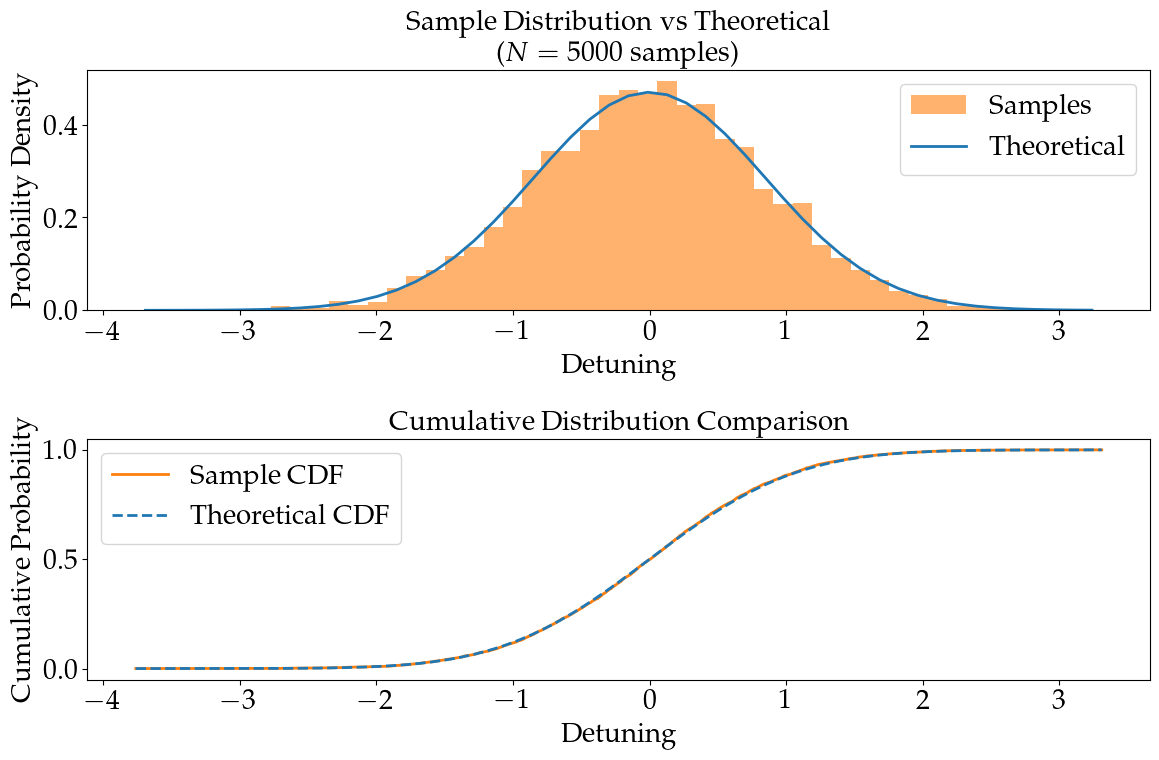

In [2]:
### Test sigma function (normalized Gaussian)
print("Testing sigma function (normalized Gaussian distribution)...")

# Test basic functionality
detunings = np.linspace(-5, 5, 40000)
FWHM_val = 2.0
sigma_val = FWHM_val / (2 * np.sqrt(2 * np.log(2)))  # standard deviation from FWHM

### Test sample_from_sigma function
print("\nTesting sample_from_sigma function (rejection sampling)...")
n_samples = 5000

# Generate samples
samples = sample_from_sigma(n_samples, FWHM_val, mu=0, max_detuning=3.0)

# Test statistical properties
sample_mean = np.mean(samples)
sample_std = np.std(samples)
print(f"Sample statistics: mean = {sample_mean:.6f}, std = {sample_std:.6f}")
print(f"Expected: mean ≈ 0, std ≈ {FWHM_val / (2 * np.sqrt(2 * np.log(2))) :.6f}")

### Visualization of sampling results
plt.figure(figsize=(12, 8))

# Plot 2: Sample histogram vs theoretical
plt.subplot(2, 1, 1)
hist_counts, hist_bins, _ = plt.hist(samples, bins=50, density=True, alpha=0.6, 
                                   color='C1', label='Samples')
bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
theoretical = normalized_gauss(bin_centers, FWHM_val, mu=0)
# Test normalization (integral should be approximately 1)

plt.plot(bin_centers, theoretical, 'C0', linewidth=2, label='Theoretical')
plt.xlabel(r'Detuning')
plt.ylabel('Probability Density')
plt.title(f'Sample Distribution vs Theoretical\n($N = {n_samples}$ samples)')
plt.legend()

# Plot 3: Cumulative distribution comparison
plt.subplot(2, 1, 2)
sorted_samples = np.sort(samples)
cumulative = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)
plt.plot(sorted_samples, cumulative, 'C1', label='Sample CDF', linewidth=2)

# Theoretical CDF (using scipy for accuracy)
from scipy.stats import norm
theoretical_cdf = norm.cdf(sorted_samples, 0, sigma_val)
plt.plot(sorted_samples, theoretical_cdf, 'C0--', label='Theoretical CDF', linewidth=2)
plt.xlabel(r'Detuning')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Comparison')
plt.legend()

## Test 2: checking all solverS (compute_pulse_evolution)

In [3]:
# =============================
# TEST 2: SOLVER VALIDATION (CHECK_THE_SOLVER)
# =============================

### Test check_the_solver function
print("Testing check_the_solver function...")
solvers = ["BR", "ME", "Paper_BR", "Paper_eqs"]
times = np.linspace(-10, 1000, 201)  # time array: 0 to 100 with dt=0.5
for solver in solvers:
    print(f"Solver: {solver}")
    system_test = SystemParameters(
        ODE_Solver=solver
    )
    res, time_cut = check_the_solver(times, system_test)
    print(f"Time cut: {time_cut}")

Testing check_the_solver function...
Solver: BR
Checking 'BR' solver 
Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9bb5f0c040>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9baddc5120>]]
Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9c07678900>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9bf6738d60>]]
Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], s

Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9bac121260>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9bac1211c0>]]
Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9bac1214e0>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9bac121580>]]


/home/leopold/Projects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/utilities.py:53: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9bac121620>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x7b9bac121300>]]


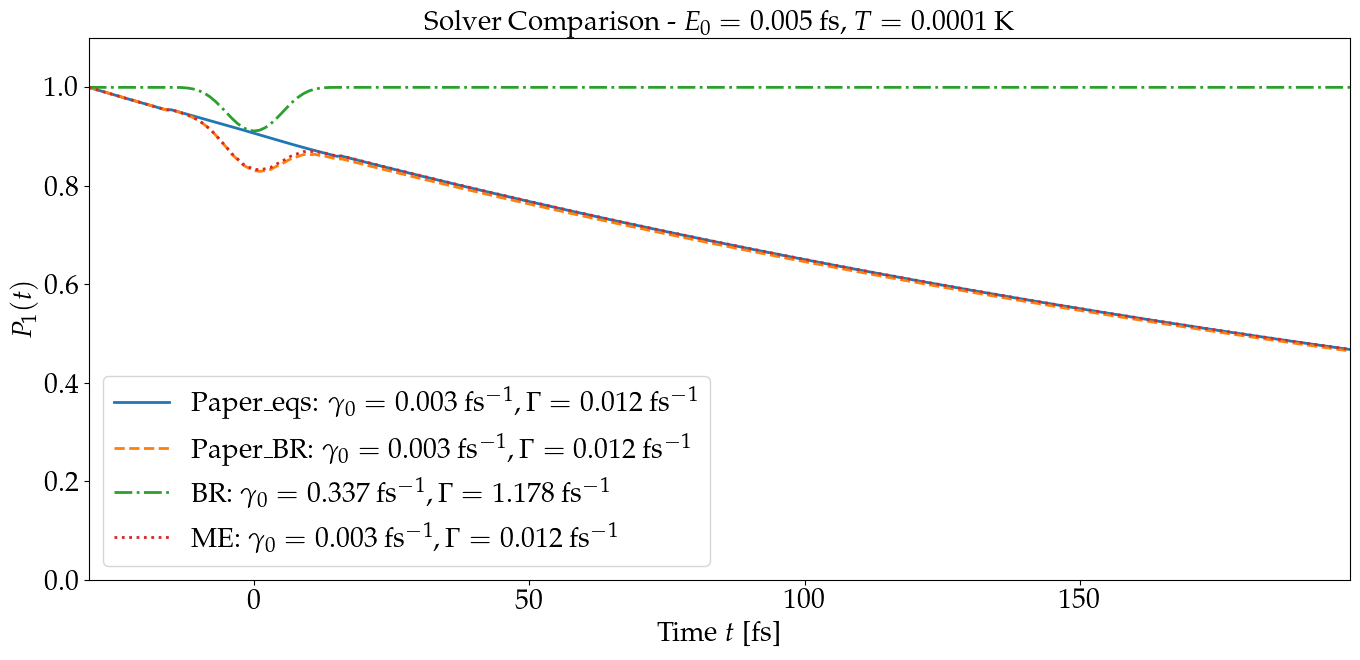

In [4]:
import qutip as qt
from qspectro2d.core.pulse_sequences import PulseSequence
# =============================
# MULTI-SOLVER DECAY COMPARISON
# =============================

### Define solvers to compare
solvers = ["Paper_eqs", "Paper_BR", "BR", "ME"]
colors  = ['C0', 'C1', 'C2', 'C3']
styles  = ['solid', 'dashed', 'dashdot', 'dotted']

### Storage for results
results_dict     = {}
populations_dict = {}

### Run simulation for each solver
psi_0_test = qt.basis(2, 1)
e_ops      = [qt.ket2dm(qt.basis(2, 1))]  # |0⟩⟨0| and |1⟩⟨1|
### Create system parameters for current solver
system_current = SystemParameters(
    t_max=200.0,
    dt=1,
    envelope_type="gaussian",
    pulse_FWHM=15.0,
    omega_A_cm=1600.0,
    E0=0.005,
    RWA_laser=True,
    psi_ini=psi_0_test,
    Temp=1e-4
)

plt.figure(figsize=(14, 7))

for i, solver in enumerate(solvers):

    system_current.ODE_Solver = solver    
    ### Compute evolution
    times  = np.arange(-2 * system_current.FWHMs[0], system_current.t_max, system_current.dt)
    result = compute_pulse_evolution(
        psi_ini=psi_0_test, 
        times=times, 
        pulse_seq=PulseSequence().from_pulse_specs(system_current, [(0,0,1), ]), 
        system=system_current
    )
        
    ### Plot 1: All excited state populations together
    plt.subplot(1, 1, 1)
    gamma_0 = system_current.gamma_0
    Gamma = system_current.Gamma
    if solver == "BR":
        gamma_0 = system_current.coupling_paper(system_current.gamma_0)
        Gamma = system_current.coupling_paper(system_current.Gamma)

    plt.plot(times, qt.expect(e_ops[0], result.states), # |1⟩⟨1| 
            label=rf'{solver}: $\gamma_0 = {gamma_0:.3f}$ fs$^{{-1}}, \Gamma={Gamma:.3f}$ fs$^{{-1}}$',
            color=colors[i], 
            linestyle=styles[i],
            linewidth=2)

    plt.xlabel(r'Time $t$ [fs]')
    plt.ylabel(r'$P_1(t)$')
    plt.title(f'Solver Comparison - $E_0 = {system_current.E0:.3f}$ fs, $T = {system_current.Temp}$ K')
    plt.legend()
    plt.xlim(times[0], times[-1])
    plt.ylim(0, 1.1)
plt.show()

/home/leopold/Projects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/utilities.py:53: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


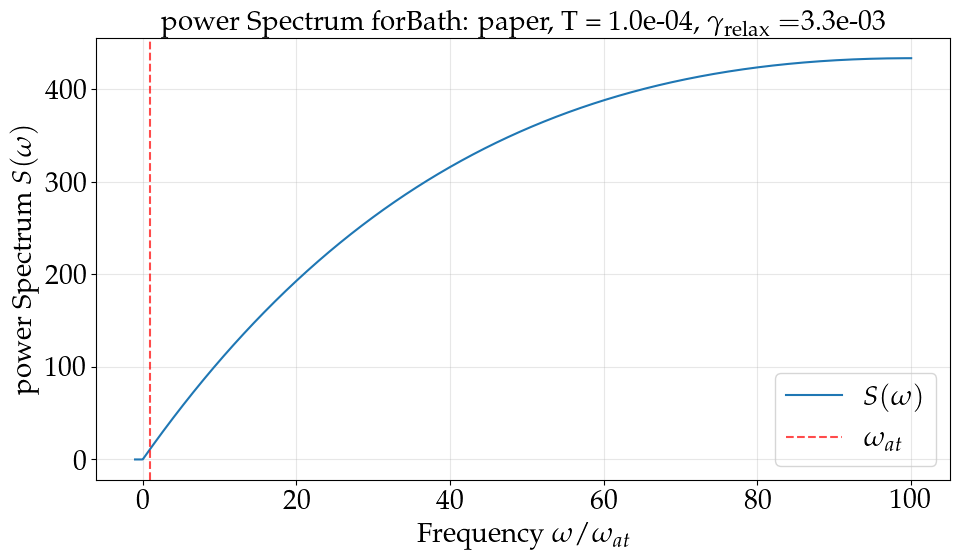

power spectrum at ω = 0: 3.910e-03
power spectrum at ω = ω_at: 1.167e+01
power spectrum at ω = cutoff: 4.335e+02

Channel arguments used:


In [4]:
# =============================
# VISUALIZE POWER SPECTRUM FUNCTION
# =============================

### Extract the power spectrum function and its parameters from the system_current
current_P_fct = system_current.br_decay_channels[0][1]  # This is the power spectrum function for the first decay channel

### Create frequency range for visualization
w_max = 1 * system_current.cutoff  # Maximum frequency
w_range = np.linspace(-0.01*w_max, w_max, 1000)

### Calculate power spectrum values
power_values = [current_P_fct(w) for w in w_range]
power_values = np.array(power_values)

### Create the plot
plt.figure(figsize=(10, 6))

### Plot the power spectrum
plt.plot(w_range / system_current.omega_A, power_values, 
         label=r'$S(\omega)$', linestyle='solid', color='C0')

if np.any(np.imag(power_values) != 0):
    plt.plot(w_range / system_current.omega_A, np.imag(power_values), 
             label=r'$S(\omega)$ (Imag)', linestyle='dashed', color='C1')

### Add vertical lines at characteristic frequencies
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label=r'$\omega_{at}$')

### Formatting
plt.xlabel(r'Frequency $\omega / \omega_{at}$')
plt.ylabel(r'power Spectrum $S(\omega)$')
plt.title(f'power Spectrum for' + 
          f'Bath: paper, T = {system_current.Temp:.1e}, ' + 
          r'$\gamma_{\mathrm{relax}} = $' + f'{system_current.gamma_0:.1e}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Print some key values
print(f"power spectrum at ω = 0: {current_P_fct(0):.3e}")
print(f"power spectrum at ω = ω_at: {current_P_fct(system_current.omega_A):.3e}")
print(f"power spectrum at ω = cutoff: {current_P_fct(system_current.cutoff):.3e}")
print(f"\nChannel arguments used:")

## Test 3: compute_1d_polarization

Testing compute_1d_polarization with parameters:

The times run from -300.00 to 1898.00 with dt = 2.000
Processing 1 frequencies with 4×4 phase combinations
Using 8 parallel workers for phase combinations

Processing frequency 1/1: ω_A = 16038.92 cm⁻¹
  Completed 4/16 phase combinations
  Completed 8/16 phase combinations
  Completed 12/16 phase combinations
  Completed 16/16 phase combinations
  Performing IFT for frequency 1/1...
  ✅ IFT completed for frequency 1

Averaging over 2 frequencies...
✅ Successfully averaged 2/1 frequency results
✓ parallel_compute_1d_E_with_inhomogenity executed successfully.


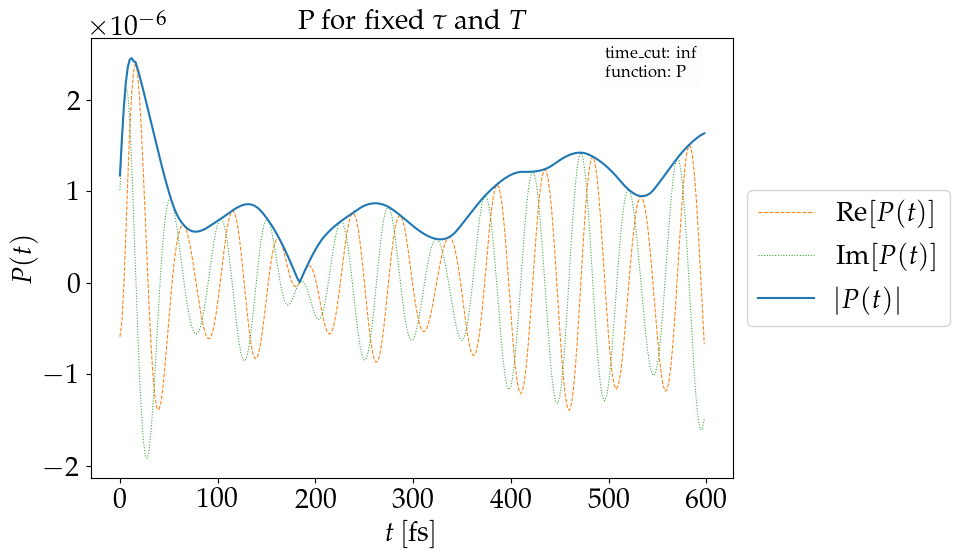

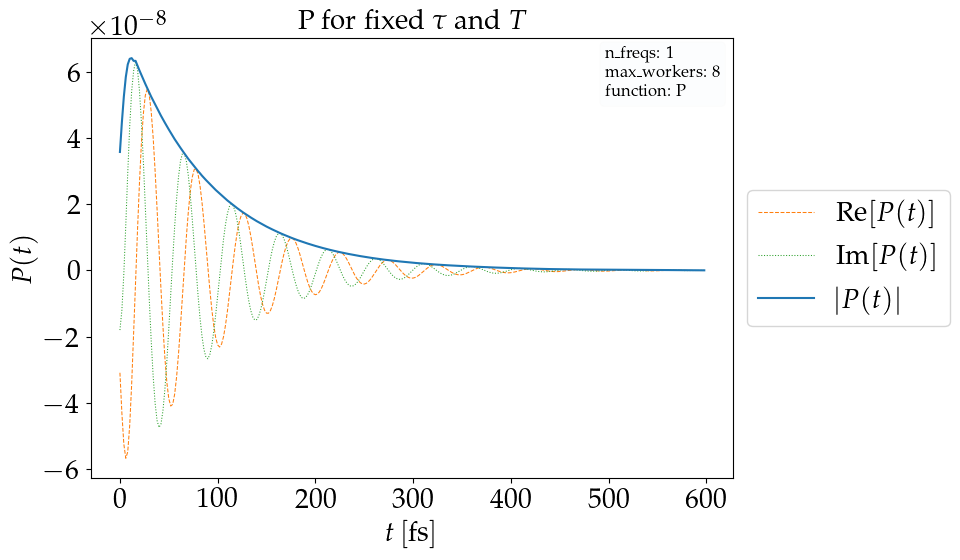

✓ compute_1d_polarization executed successfully.


In [ ]:
# Test compute_1d_polarization for dummy variables

# Define dummy input values
tau_coh_test = 300.0
T_wait_test  = 1000.0
phi_0_test   = 0.0
phi_1_test   = 0.0*np.pi / 2
system_test  = SystemParameters(
    t_max=tau_coh_test + T_wait_test + 600.0,  # Maximum time for simulation
    dt=2,      # Time step
    envelope_type="gaussian",  # Use Gaussian pulse envelope
    pulse_FWHM=15.0,
    omega_A_cm=16000.0,
    E0=0.005,
    ODE_Solver="Paper_eqs",  # Use Paper BR solver
    RWA_laser= True,  # Use RWA for laser
#    gamma_phi=0.20,  # No dephasing
#    gamma_0=0.1
)  # Use default parameters
t_max = system_test.t_max  # Maximum time for simulation
# Create time array from -FWHM to t_max with dt
times   = np.arange(-20* system_test.FWHMs[0], t_max, system_test.dt)  # Time array from 0 to t_max with dt
print(f"Testing compute_1d_polarization with parameters:\n")
print(f"The times run from {times[0]:.2f} to {times[-1]:.2f} with dt = {system_test.dt:.3f}")
time_cut = np.inf
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
#    "tau_coh": tau_coh_test,
#    "T_wait": T_wait_test,
    "function": "P" # Polarization function 
}

try:
    result = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times,
        system=system_test,
        **kwargs
    )
    # now also make a resutl = parallel_compute_1d_E_with_inhomogenity(...) 
    
    ### Test parallel_compute_1d_E_with_inhomogenity with inhomogeneous broadening
    kwargs_parallel = {
        "n_freqs":1,  # Number of phases for phase cycling (should be 4 for IFT)
        # to avoid numerical issues
        "max_workers": 8,  # Number of parallel workers (adjust based on your CPU)
    }
    kwargs_parallel.update({
        "function": "E_{k_s}" if kwargs_parallel["n_freqs"] > 1 else "P",
  
        }
        )  # Polarization function    
    result_parallel = parallel_compute_1d_E_with_inhomogenity(
        n_phases=4,  # Number of frequencies for inhomogeneous broadening
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        times=times,
        system=system_test,
        **kwargs_parallel
    )
    print("✓ parallel_compute_1d_E_with_inhomogenity executed successfully.")
    
    # Plot the data for a fixed tau_coh and T_wait
    Plot_fixed_tau_T(
        result[0], result[1], **kwargs
    )
    Plot_fixed_tau_T(
        result_parallel[0], result_parallel[1], **kwargs_parallel
    )
    print("✓ compute_1d_polarization executed successfully.")
except Exception as e:
    print("❌ compute_1d_polarization failed:", e)

In [ ]:
# =============================
# TEST: extract_ift_signal_component Function
# =============================

import numpy as np
from qspectro2d.spectroscopy.calculations import extract_ift_signal_component

print("Testing extract_ift_signal_component function...")

# Test parameters
n_phases = 4
phases = np.array([0, np.pi/2, np.pi, 3*np.pi/2])
data_shape = (10, 15)  # Example 2D signal shape

# Create synthetic test data with known phase relationship
# We'll create data where each phase combination has: base_signal * exp(i*(l*phi1 + m*phi2))
base_signal = np.random.randn(*data_shape) + 1j * np.random.randn(*data_shape)
l_test, m_test = -1, 1  # Test coefficients (e.g., rephasing pathway)

# Fill results matrix with phase-modulated data
results_matrix = np.zeros((n_phases, n_phases), dtype=object)
for phi1_idx, phi1 in enumerate(phases):
    for phi2_idx, phi2 in enumerate(phases):
        # Add known phase modulation
        phase_factor = np.exp(1j * (l_test * phi1 + m_test * phi2))
        results_matrix[phi1_idx, phi2_idx] = base_signal * phase_factor

print(f"Created test matrix: {results_matrix.shape}")
print(f"Data shape per phase: {results_matrix[0,0].shape}")

# Extract signal component
extracted_signal = extract_ift_signal_component(results_matrix, phases, l_test, m_test)

# Verify the result
if extracted_signal is not None:
    # The IFT should reconstruct the original base signal
    reconstruction_error = np.mean(np.abs(extracted_signal - base_signal))
    print(f"✓ Function executed successfully")
    print(f"✓ Output shape: {extracted_signal.shape}")
    print(f"✓ Reconstruction error: {reconstruction_error:.2e}")
    
    if reconstruction_error < 1e-10:
        print("✓ Perfect reconstruction - function works correctly!")
    else:
        print(f"⚠ Reconstruction error: {reconstruction_error:.2e}")
else:
    print("❌ Function returned None")

# Test edge case: missing data
print("\nTesting with missing data...")
results_matrix[0, 0] = None  # Remove one phase combination
extracted_with_missing = extract_ift_signal_component(results_matrix, phases, l_test, m_test)

if extracted_with_missing is not None:
    print("✓ Handles missing data correctly")
else:
    print("❌ Failed with missing data")

Testing extract_ift_signal_component function...
Created test matrix: (4, 4)
Data shape per phase: (10, 15)
✓ Function executed successfully
✓ Output shape: (10, 15)
✓ Reconstruction error: 1.40e-07
⚠ Reconstruction error: 1.40e-07

Testing with missing data...
✓ Handles missing data correctly


Creating visualization with 2D Gaussian input...
Created 2D Gaussian: shape (32, 40)
  Center: tau=10, t=-5
  Widths: sigma_tau=15, sigma_t=20
IFT coefficients l=-1, m= 1:
  Reconstruction error: 2.899e-08 (relative: 0.00%)
  Max amplitude - Original: 1.992, Extracted: 1.992
  ✓ Excellent reconstruction!
IFT coefficients l= 1, m=-1:
  Reconstruction error: 2.899e-08 (relative: 0.00%)
  Max amplitude - Original: 1.992, Extracted: 1.992
  ✓ Excellent reconstruction!
IFT coefficients l= 0, m= 1:
  Reconstruction error: 2.899e-08 (relative: 0.00%)
  Max amplitude - Original: 1.992, Extracted: 1.992
  ✓ Excellent reconstruction!
IFT coefficients l= 1, m= 0:
  Reconstruction error: 2.899e-08 (relative: 0.00%)
  Max amplitude - Original: 1.992, Extracted: 1.992
  ✓ Excellent reconstruction!


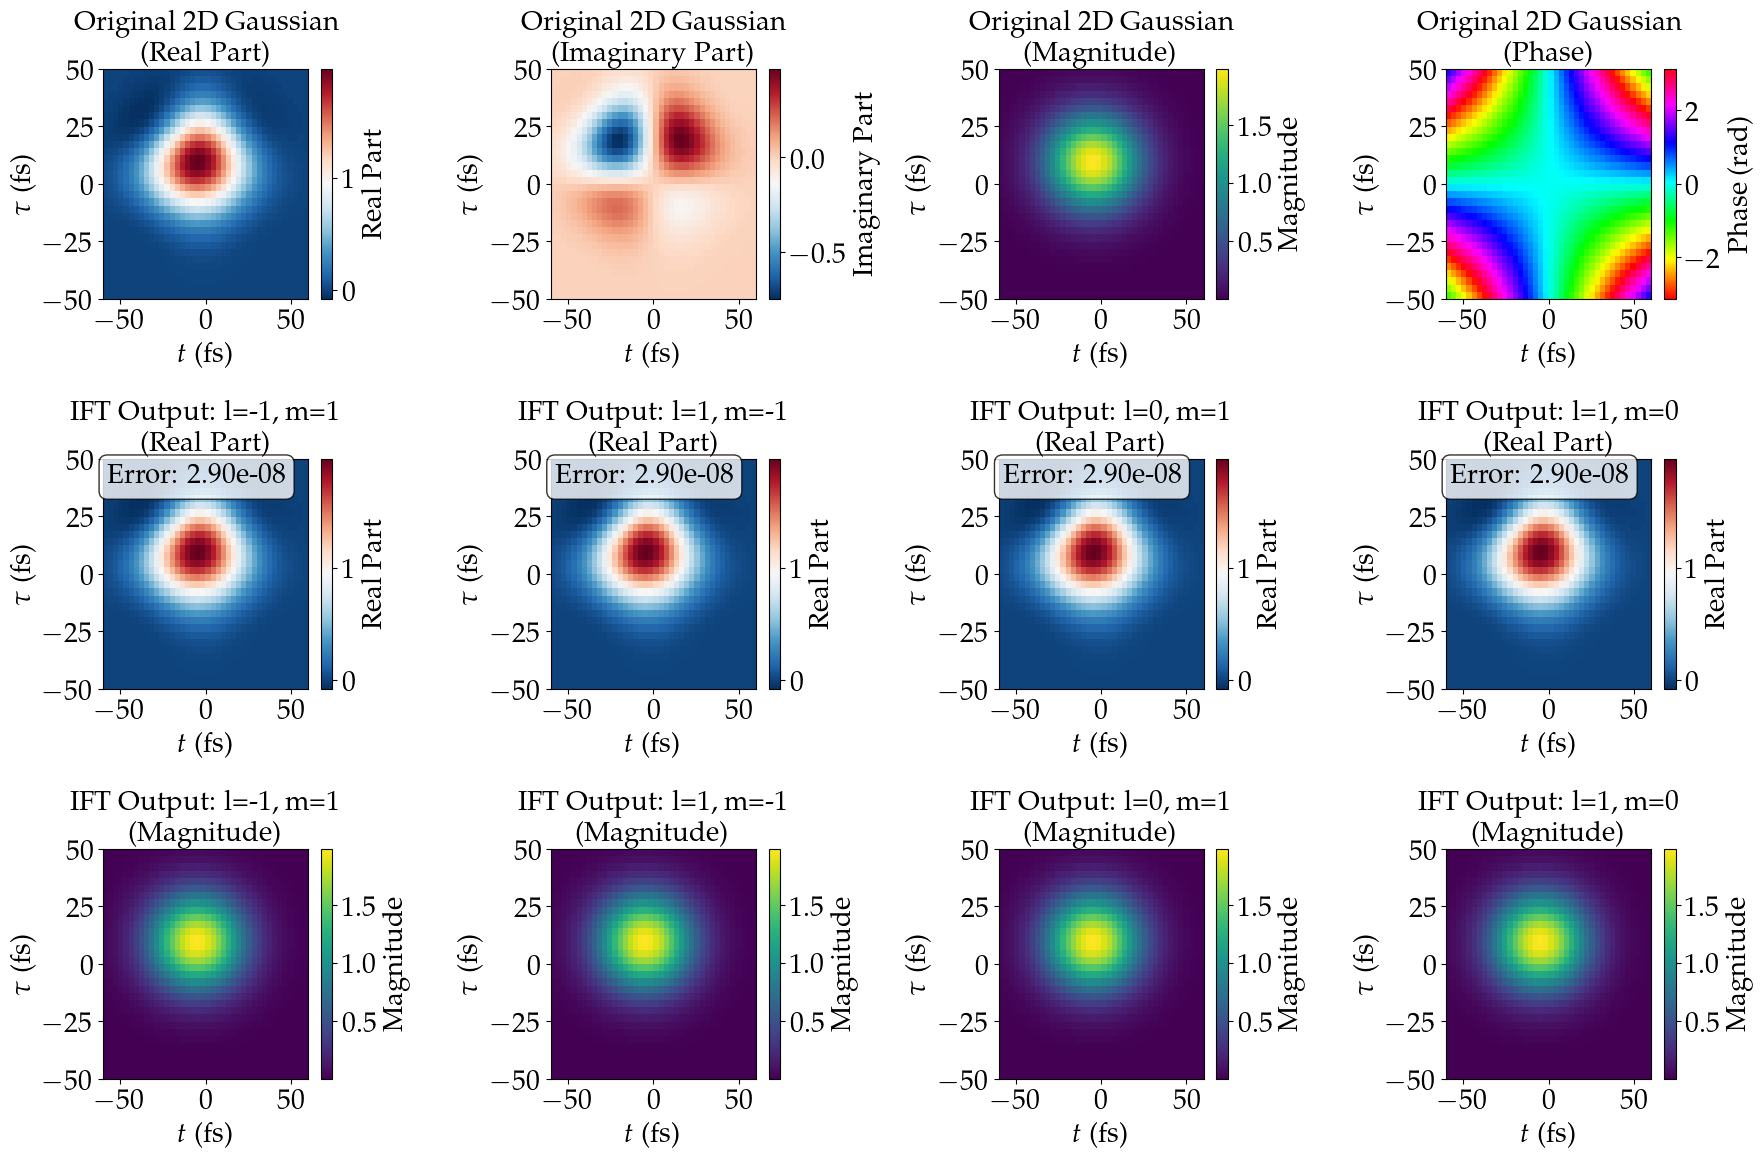


VISUALIZATION SUMMARY
This visualization shows how extract_ift_signal_component works:
1. Input: 2D Gaussian with complex phase structure
2. Phase modulation: Applied exp(i*(l*φ₁ + m*φ₂)) to create phase cycling data
3. IFT extraction: Used different (l,m) coefficients to extract signal components
4. Expected result: Perfect reconstruction when extraction coefficients match modulation


In [ ]:
# =============================
# VISUALIZATION: 2D Gaussian Input vs Output
# =============================

import matplotlib.pyplot as plt
from qspectro2d.spectroscopy.calculations import extract_ift_signal_component

print("Creating visualization with 2D Gaussian input...")

### Create 2D Gaussian as base signal
tau_size, t_size = 32, 40
tau_coords = np.linspace(-50, 50, tau_size)
t_coords = np.linspace(-60, 60, t_size)
TAU, T = np.meshgrid(tau_coords, t_coords, indexing='ij')

# Create 2D Gaussian with specific parameters
tau_center, t_center = 10, -5
sigma_tau, sigma_t = 15, 20
amplitude = 2.0

gaussian_2d = amplitude * np.exp(
    -((TAU - tau_center)**2 / (2 * sigma_tau**2) + 
      (T - t_center)**2 / (2 * sigma_t**2))
)

# Add some complex phase structure to make it more realistic
phase_structure = 0.5 * TAU * T / (sigma_tau * sigma_t)
gaussian_2d_complex = gaussian_2d * np.exp(1j * phase_structure)

print(f"Created 2D Gaussian: shape {gaussian_2d_complex.shape}")
print(f"  Center: tau={tau_center}, t={t_center}")
print(f"  Widths: sigma_tau={sigma_tau}, sigma_t={sigma_t}")

### Test different IFT coefficients with the 2D Gaussian
n_phases = 4
phases = np.array([0, np.pi/2, np.pi, 3*np.pi/2])
test_coefficients = [(-1, 1), (1, -1), (0, 1), (1, 0)]

plt.figure(figsize=(18, 12))

### Plot original 2D Gaussian
plt.subplot(3, 4, 1)
plt.imshow(np.real(gaussian_2d_complex), aspect='auto', origin='lower',
           extent=[t_coords[0], t_coords[-1], tau_coords[0], tau_coords[-1]],
           cmap='RdBu_r')
plt.colorbar(label='Real Part')
plt.xlabel(r'$t$ (fs)')
plt.ylabel(r'$\tau$ (fs)')
plt.title('Original 2D Gaussian\n(Real Part)')

plt.subplot(3, 4, 2)
plt.imshow(np.imag(gaussian_2d_complex), aspect='auto', origin='lower',
           extent=[t_coords[0], t_coords[-1], tau_coords[0], tau_coords[-1]],
           cmap='RdBu_r')
plt.colorbar(label='Imaginary Part')
plt.xlabel(r'$t$ (fs)')
plt.ylabel(r'$\tau$ (fs)')
plt.title('Original 2D Gaussian\n(Imaginary Part)')

plt.subplot(3, 4, 3)
plt.imshow(np.abs(gaussian_2d_complex), aspect='auto', origin='lower',
           extent=[t_coords[0], t_coords[-1], tau_coords[0], tau_coords[-1]],
           cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel(r'$t$ (fs)')
plt.ylabel(r'$\tau$ (fs)')
plt.title('Original 2D Gaussian\n(Magnitude)')

plt.subplot(3, 4, 4)
plt.imshow(np.angle(gaussian_2d_complex), aspect='auto', origin='lower',
           extent=[t_coords[0], t_coords[-1], tau_coords[0], tau_coords[-1]],
           cmap='hsv')
plt.colorbar(label='Phase (rad)')
plt.xlabel(r'$t$ (fs)')
plt.ylabel(r'$\tau$ (fs)')
plt.title('Original 2D Gaussian\n(Phase)')

### Test each IFT coefficient pair
for idx, (l, m) in enumerate(test_coefficients):
    
    ### Create phase-modulated results matrix
    results_matrix_gauss = np.zeros((n_phases, n_phases), dtype=object)
    
    for phi1_idx, phi1 in enumerate(phases):
        for phi2_idx, phi2 in enumerate(phases):
            # Apply phase modulation: exp(i*(l*phi1 + m*phi2))
            phase_factor = np.exp(1j * (l * phi1 + m * phi2))
            results_matrix_gauss[phi1_idx, phi2_idx] = gaussian_2d_complex * phase_factor
    
    ### Extract signal component
    extracted = extract_ift_signal_component(results_matrix_gauss, phases, l, m)
    
    if extracted is not None:
        ### Plot extracted signal (real part)
        plt.subplot(3, 4, 5 + idx)
        plt.imshow(np.real(extracted), aspect='auto', origin='lower',
                   extent=[t_coords[0], t_coords[-1], tau_coords[0], tau_coords[-1]],
                   cmap='RdBu_r')
        plt.colorbar(label='Real Part')
        plt.xlabel(r'$t$ (fs)')
        plt.ylabel(r'$\tau$ (fs)')
        plt.title(f'IFT Output: l={l}, m={m}\n(Real Part)')
        
        ### Calculate reconstruction error
        error = np.mean(np.abs(extracted - gaussian_2d_complex))
        plt.text(0.02, 0.98, f'Error: {error:.2e}', 
                transform=plt.gca().transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ### Plot extracted signal magnitude
        plt.subplot(3, 4, 9 + idx)
        plt.imshow(np.abs(extracted), aspect='auto', origin='lower',
                   extent=[t_coords[0], t_coords[-1], tau_coords[0], tau_coords[-1]],
                   cmap='viridis')
        plt.colorbar(label='Magnitude')
        plt.xlabel(r'$t$ (fs)')
        plt.ylabel(r'$\tau$ (fs)')
        plt.title(f'IFT Output: l={l}, m={m}\n(Magnitude)')
        
        ### Print reconstruction quality
        max_original = np.max(np.abs(gaussian_2d_complex))
        max_extracted = np.max(np.abs(extracted))
        relative_error = error / max_original
        
        print(f"IFT coefficients l={l:2d}, m={m:2d}:")
        print(f"  Reconstruction error: {error:.3e} (relative: {relative_error:.2%})")
        print(f"  Max amplitude - Original: {max_original:.3f}, Extracted: {max_extracted:.3f}")
        
        if relative_error < 0.01:  # Less than 1% error
            print(f"  ✓ Excellent reconstruction!")
        elif relative_error < 0.1:  # Less than 10% error
            print(f"  ✓ Good reconstruction")
        else:
            print(f"  ⚠ Poor reconstruction")
    else:
        print(f"IFT coefficients l={l:2d}, m={m:2d}: ❌ Failed (returned None)")

plt.tight_layout()
plt.show()

### Summary of the visualization
print("\n" + "="*60)
print("VISUALIZATION SUMMARY")
print("="*60)
print("This visualization shows how extract_ift_signal_component works:")
print("1. Input: 2D Gaussian with complex phase structure")
print("2. Phase modulation: Applied exp(i*(l*φ₁ + m*φ₂)) to create phase cycling data")
print("3. IFT extraction: Used different (l,m) coefficients to extract signal components")
print("4. Expected result: Perfect reconstruction when extraction coefficients match modulation")
print("="*60)

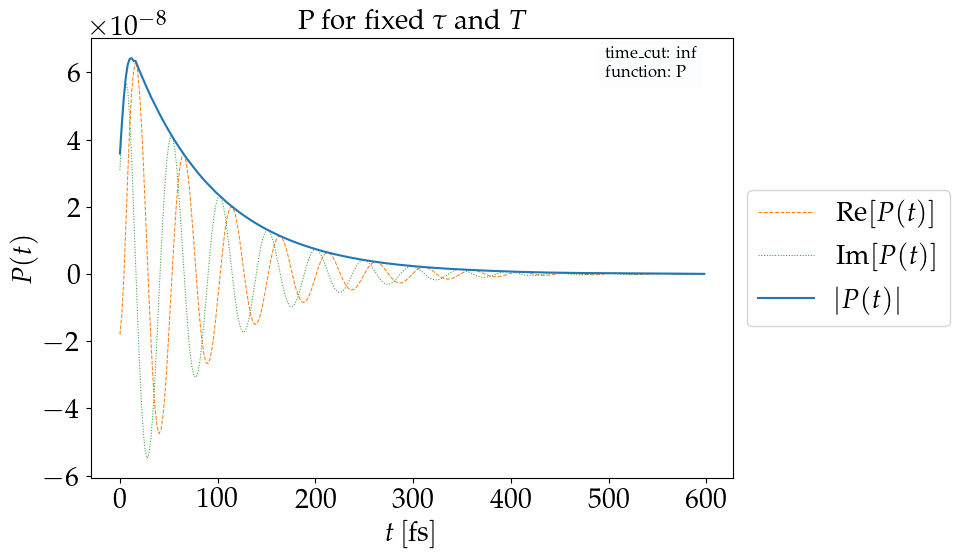

✓ extract_ift_signal_component succeeded!
First 5 values: [-1.80443749e-08+3.0966476e-08j -1.20344339e-08+4.3204636e-08j
 -9.28594091e-10+5.2561518e-08j  1.38170435e-08+5.6839781e-08j
  2.95258360e-08+5.4875272e-08j]


In [ ]:
from qspectro2d.spectroscopy.calculations import _process_single_1d_combination, _process_single_2d_combination
# =============================
# TEST: extract_ift_signal_component Function
# =============================
# Use result from compute_1d_polarization as test input
n_phases = 4 # typical for phase cycling
phases= np.array([0, np.pi/2, np.pi, 3*np.pi/2])  # example phase values
signal = np.zeros((n_phases, n_phases), dtype=object)  # store the signal data

for phi1_idx, phi1 in enumerate(phases):
    for phi2_idx, phi2 in enumerate(phases):
        # _process_single_1d_combination returns a tuple (t_det_vals, data)
        result_temp = _process_single_1d_combination(
            phi1=phi1,
            phi2=phi2,
            tau_coh=tau_coh_test,  # example coherence time
            T_wait=T_wait_test,  # example waiting time
            times=times,  # example time array,
            system=system_test,  # example system parameters
            **kwargs
        )
        
        # Extract only the data part (second element of the tuple)
        if result_temp is not None:
            signal[phi1_idx, phi2_idx] = result_temp[1]  # Store only the data, not the tuple
        else:
            signal[phi1_idx, phi2_idx] = None
            print(f"❌ No result for phase combination ({phi1_idx}, {phi2_idx})")

try:
    # Extract the IFT signal component (e.g., rephasing or non-rephasing)
    # The function now receives only the data arrays, not tuples
    extracted_signal = extract_ift_signal_component(signal, phases=phases, l=-1, m=1)
    
    if extracted_signal is not None:
        Plot_fixed_tau_T(
            result_temp[0], extracted_signal, **kwargs
        )
        print(f"✓ extract_ift_signal_component succeeded!")
        print(f"First 5 values: {extracted_signal[:5]}")
    else:
        print("❌ extract_ift_signal_component returned None (no valid results)")
        
except Exception as e:
    print(f"❌ extract_ift_signal_component failed: {e}")
    import traceback
    traceback.print_exc()

Plot not saved. Ensure 'save' is True and 'output_dir' is specified.


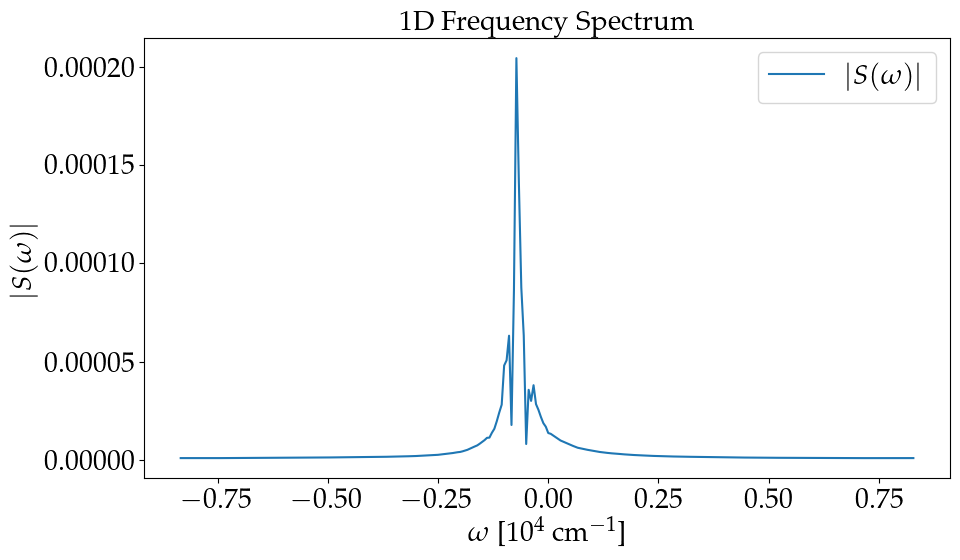

In [ ]:
t_freqs, data_freqs = compute_1d_fft_wavenumber(
    result[0], result[1])

Plot_1d_frequency_spectrum(
    t_freqs, data_freqs,
    type="abs")

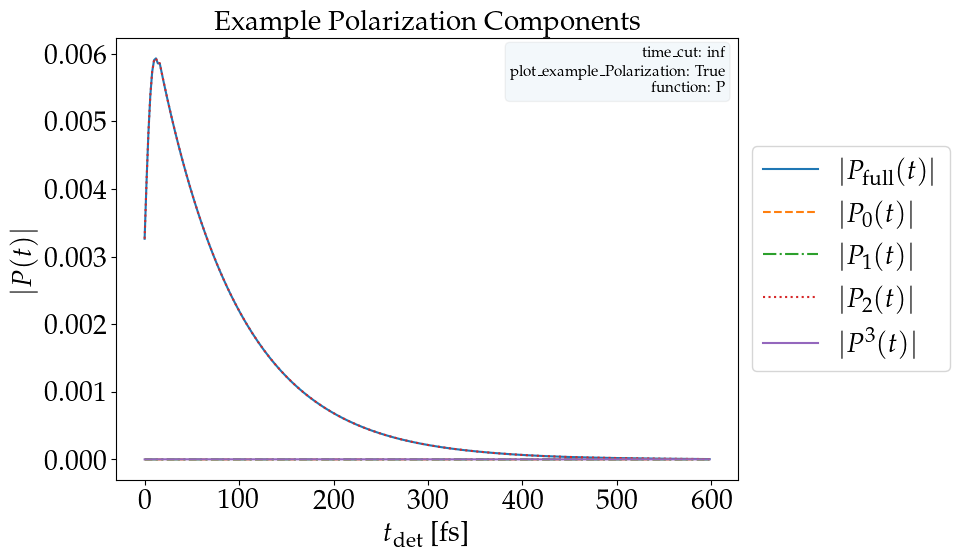

✓ compute_1d_polarization executed successfully.


In [ ]:
# Test compute_1d_polarization for dummy variables
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
#    "tau_coh": tau_coh_test,
#    "T_wait": T_wait_test,
    "plot_example_Polarization": True,  # Enable example polarization plot
    "function": "P" # Polarization function 
}

try:
    times_plot, P_full, P_only0, P_only1, P_only2 = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times,
        system=system_test,
        **kwargs  # Unpack the kwargs dictionary with **
    )
    # Plot the data for a fixed tau_coh and T_wait
    Plot_example_Polarization(
        times_plot, P_full, P_only0, P_only1, P_only2, **kwargs  # Unpack kwargs here too
    )
    print("✓ compute_1d_polarization executed successfully.")
except Exception as e:
    print("❌ compute_1d_polarization failed:", e)


Setting up test parameters...


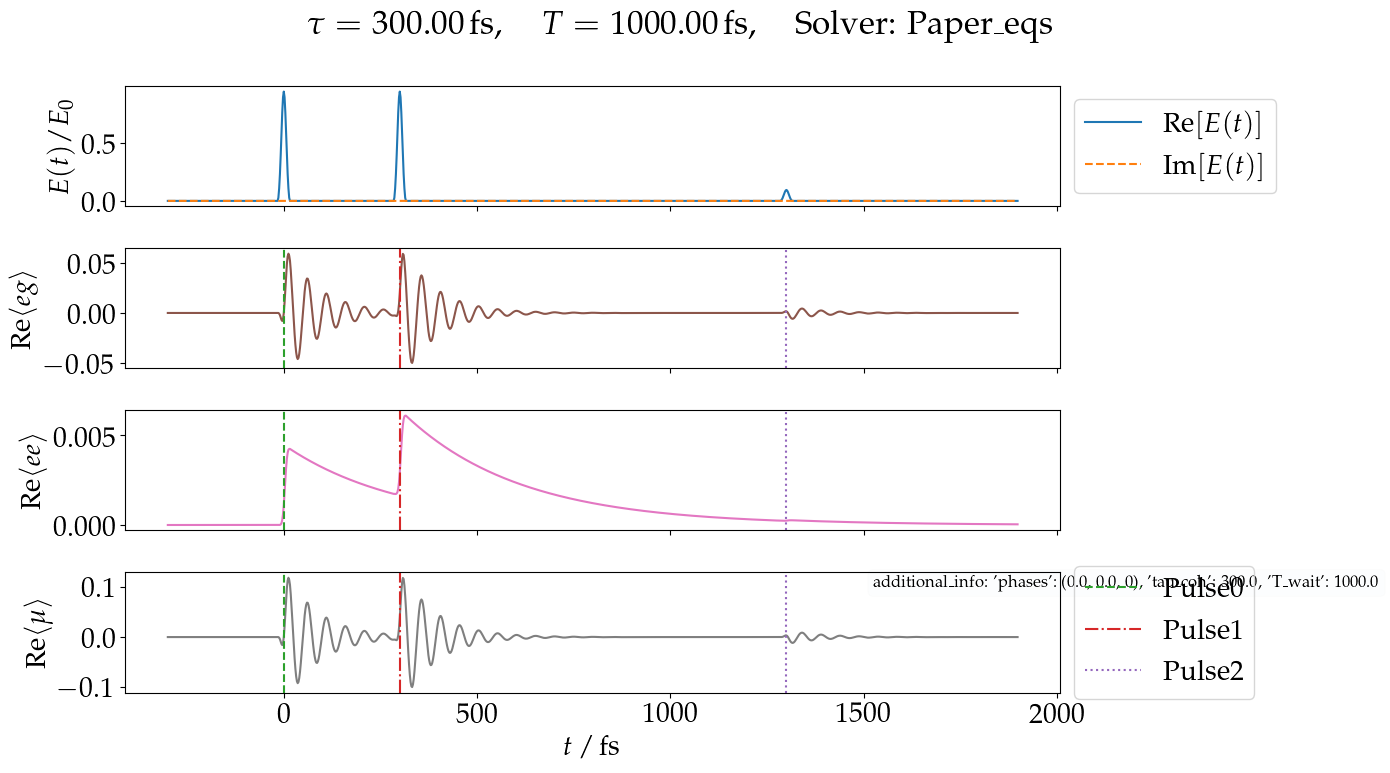

Example evolution plot created successfully.


In [ ]:
### Create test system and time arrays
print("\nSetting up test parameters...")

# Plot an example evolution:
kwargs = {
    "plot_example": True,
    "time_cut": time_cut,
}

try:
    res = compute_1d_polarization(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times,
        system=system_test,
        **kwargs  # Unpack the kwargs dictionary with **
    )
    times_plot, data_expectations, pulse_seq_f, additional_info = res[:]

    Plot_example_evo(times_plot, data_expectations, pulse_seq_f, tau_coh=tau_coh_test, T_wait=T_wait_test, system=system_test, additional_info=additional_info)
    print(f"Example evolution plot created successfully.")
except Exception as e:
    print(f"Error during compute_2d_polarization: {e}")


❌ compute_1d_polarization failed: qspectro2d.spectroscopy.calculations.parallel_compute_1d_E_with_inhomogenity() got multiple values for keyword argument 'n_freqs'
Plot not saved. Ensure 'save' is True and 'output_dir' is specified.


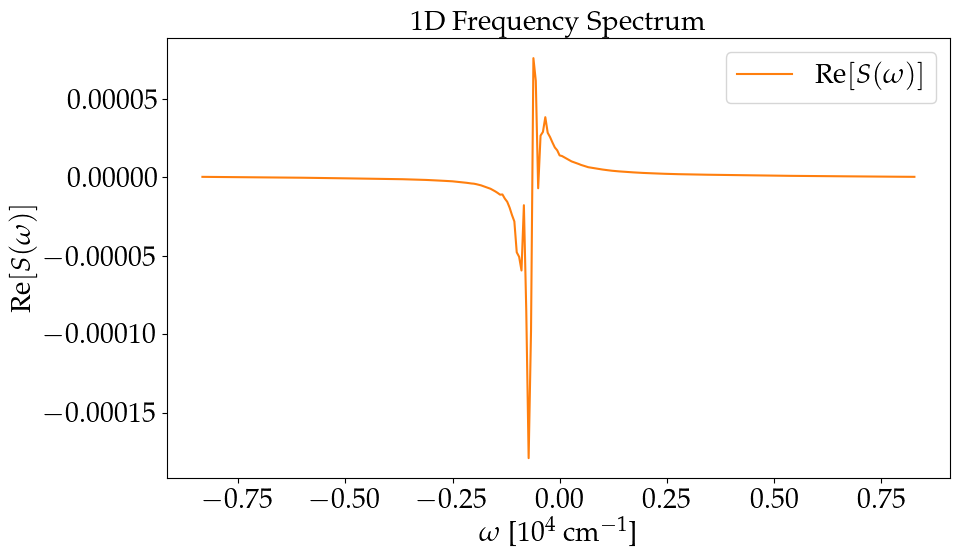

In [ ]:
kwargs = {
    "time_cut": time_cut,  # to avoid numerical issues
#    "tau_coh": tau_coh_test,
#    "T_wait": T_wait_test,
    "function": "E_{ks}",  # Electric field function
    "n_freqs":10,
}

try:
    result = parallel_compute_1d_E_with_inhomogenity(n_freqs=kwargs["n_freqs"], n_phases=4, tau_coh=tau_coh_test, T_wait=T_wait_test, times=times, system=system_test, **kwargs)
    # Plot the data for a fixed tau_coh and T_wait
    Plot_fixed_tau_T(
        result[0], result[1], **kwargs
    )
    print("✓ compute_1d_polarization executed successfully.")
except Exception as e:
    print("❌ compute_1d_polarization failed:", e)

t_freqs, data_freqs = compute_1d_fft_wavenumber(
    result[0], result[1])

Plot_1d_frequency_spectrum(
    t_freqs, data_freqs,
    type="real"
)

## Test 4: get_tau_cohs_and_t_dets_for_T_wait

Testing get_tau_cohs_and_t_dets_for_T_wait function...
Generated time arrays:
  Input times: 201 points, range [-2.00, 100.00], dt = 0.510
  T_wait = 50.0
  tau_cohs: 99 points, range [0.00, 49.98]
  t_dets: 99 points, range [0.00, 49.98]

Testing T_wait = t_max (edge case):
  T_wait = t_max = 100.0: tau_cohs length = 1, t_dets length = 1
    Values: tau_coh = [0.], t_det = [0.]

Testing T_wait > t_max (should return empty):
  T_wait = 110.0 > t_max = 100.0: tau_cohs length = 0, t_dets length = 0

Testing single time point:
  Single time point: tau_cohs = [0.], t_dets = [0.]

Creating visualizations...


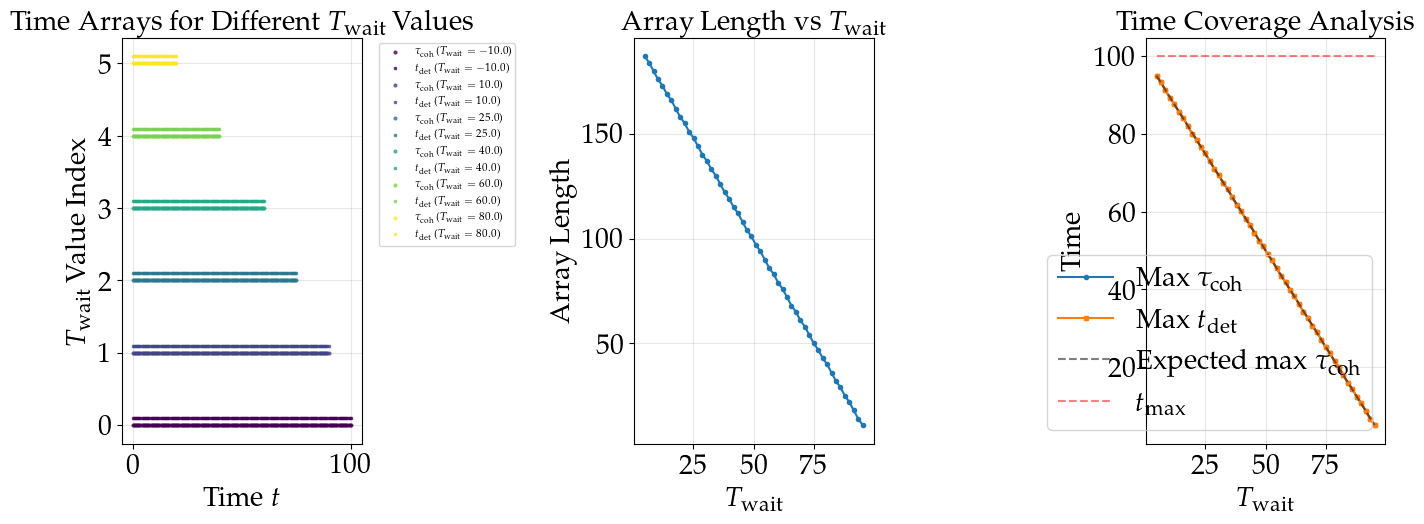


✓ All time array calculation tests passed!


In [ ]:
# =============================
# TEST 1: TIME ARRAY CALCULATIONS
# =============================

### Test get_tau_cohs_and_t_dets_for_T_wait function
print("Testing get_tau_cohs_and_t_dets_for_T_wait function...")

# Test basic functionality with reasonable parameters
times = np.linspace(-2, 100, 201)  # time array: 0 to 100 with dt=0.5
T_wait = 50.0  # waiting time

tau_cohs, t_dets = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)

print(f"Generated time arrays:")
print(
    f"  Input times: {len(times)} points, range [{times[0]:.2f}, {times[-1]:.2f}], dt = {times[1]-times[0]:.3f}"
)
print(f"  T_wait = {T_wait}")
print(
    f"  tau_cohs: {len(tau_cohs)} points, range [{tau_cohs[0]:.2f}, {tau_cohs[-1]:.2f}]"
)
print(f"  t_dets: {len(t_dets)} points, range [{t_dets[0]:.2f}, {t_dets[-1]:.2f}]")

# Test array properties
assert len(tau_cohs) > 0, "tau_cohs array is empty"
assert len(t_dets) > 0, "t_dets array is empty"
assert len(tau_cohs) == len(t_dets), "tau_cohs and t_dets should have same length"
assert tau_cohs[0] >= 0, "tau_cohs should start from non-negative value"
assert t_dets[0] >= 0, "t_dets should start from non-negative value"
assert (
    t_dets[-1] <= times[-1]
), f"t_dets exceeds maximum time: {t_dets[-1]} > {times[-1]}"


# Test with T_wait = t_max (edge case)
print("\nTesting T_wait = t_max (edge case):")
T_wait_max = times[-1]
tau_edge, t_det_edge = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_max)
print(
    f"  T_wait = t_max = {T_wait_max}: tau_cohs length = {len(tau_edge)}, t_dets length = {len(t_det_edge)}"
)

if len(tau_edge) > 0:
    print(f"    Values: tau_coh = {tau_edge}, t_det = {t_det_edge}")

# Test with T_wait > t_max (should return empty arrays)
print("\nTesting T_wait > t_max (should return empty):")
T_wait_large = times[-1] + 10.0
tau_empty, t_det_empty = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_large)
print(
    f"  T_wait = {T_wait_large} > t_max = {times[-1]}: tau_cohs length = {len(tau_empty)}, t_dets length = {len(t_det_empty)}"
)
assert len(tau_empty) == 0, "Should return empty array when T_wait > t_max"
assert len(t_det_empty) == 0, "Should return empty array when T_wait > t_max"

### Test with single time point
print("\nTesting single time point:")
times_single = np.array([0.0])
tau_single, t_det_single = get_tau_cohs_and_t_dets_for_T_wait(times_single, 0.0)
print(f"  Single time point: tau_cohs = {tau_single}, t_dets = {t_det_single}")

### Visualization of time arrays
print("\nCreating visualizations...")
plt.figure(figsize=(14, 10))

### Plot 1: Time arrays for different T_wait values
plt.subplot(2, 3, 1)
T_wait_vis = [-10.0, 10.0, 25.0, 40.0, 60.0, 80.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(T_wait_vis)))

for i, T_w in enumerate(T_wait_vis):
    tau_vis, t_det_vis = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    if len(tau_vis) > 0:
        plt.plot(
            tau_vis,
            np.full_like(tau_vis, i),
            "o",
            color=colors[i],
            markersize=2,
            label=rf"$\tau_{{\text{{coh}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
            alpha=0.7,
        )
        plt.plot(
            t_det_vis,
            np.full_like(t_det_vis, i + 0.1),
            "s",
            color=colors[i],
            markersize=2,
            alpha=0.7,
            label=rf"$t_{{\text{{det}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
        )
plt.xlabel(r"Time $t$")
plt.ylabel(r"$T_{\text{wait}}$ Value Index")
plt.title(r"Time Arrays for Different $T_{\text{wait}}$ Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.grid(True, alpha=0.3)

### Plot 2: Array length vs T_wait
plt.subplot(2, 3, 2)
T_wait_range = np.linspace(5, 95, 50)
array_lengths = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    array_lengths.append(len(tau_test))

plt.plot(T_wait_range, array_lengths, "C0o-", markersize=3)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Array Length")
plt.title(r"Array Length vs $T_{\text{wait}}$")
plt.grid(True, alpha=0.3)

### Plot 3: Time coverage analysis
plt.subplot(2, 3, 3)
tau_coverage = []
t_det_coverage = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    tau_max = tau_test[-1] if len(tau_test) > 0 else 0
    t_det_max = t_det_test[-1] if len(t_det_test) > 0 else 0
    tau_coverage.append(tau_max)
    t_det_coverage.append(t_det_max)

plt.plot(T_wait_range, tau_coverage, "C0o-", label=r"Max $\tau_{\text{coh}}$", markersize=3)
plt.plot(T_wait_range, t_det_coverage, "C1s-", label=r"Max $t_{\text{det}}$", markersize=3)
plt.plot(
    T_wait_range, 
    times[-1] - T_wait_range, 
    "k--", 
    alpha=0.5, 
    label=r"Expected max $\tau_{\text{coh}}$"
)
plt.plot(
    T_wait_range, 
    np.full_like(T_wait_range, times[-1]), 
    "r--", 
    alpha=0.5, 
    label=r"$t_{\text{max}}$"
)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Time")
plt.title(r"Time Coverage Analysis")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ All time array calculation tests passed!")


## Test 5: compute_2d_polarization

Testing compute_2d_polarization function...

Setting up test parameters...
System parameters:
  Time array: 250 points, dt = 0.100

Testing T_wait near time limits:
Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x701965dbfc40>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x701965dbc720>]]
Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x701965dbe700>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>

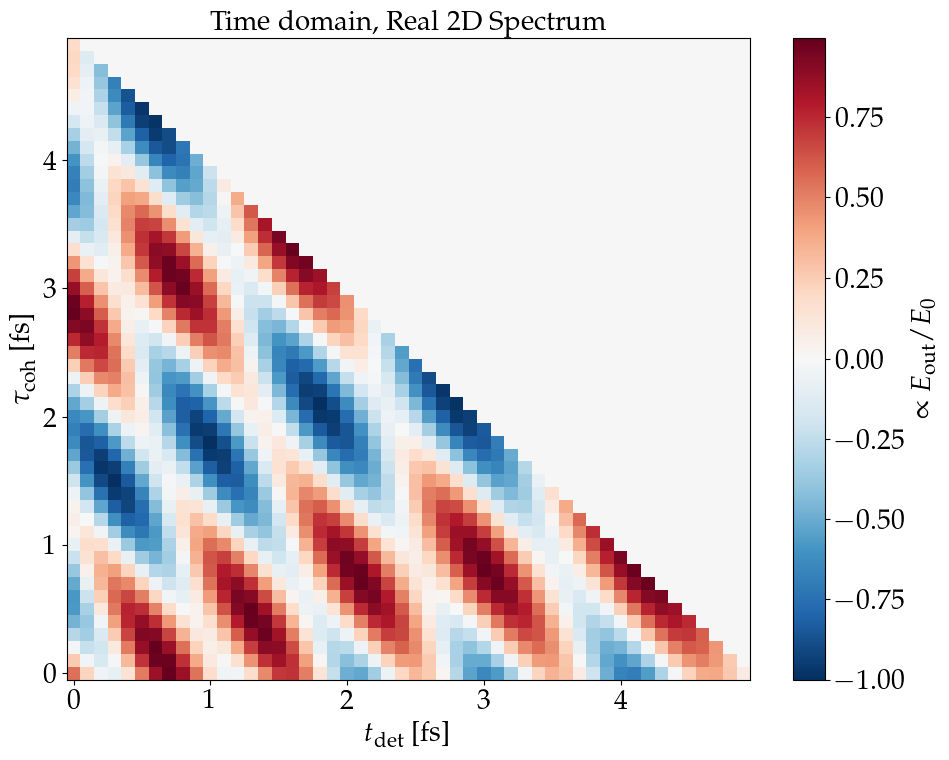

  T_wait=  5.0 (50.0% of t_max): ✓ Success, shape (50, 50)

Testing time_cut parameter:


In [ ]:
### Test compute_2d_polarization function
print("Testing compute_2d_polarization function...")

### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    t_max=10.0,  # Maximum time for simulation
    dt=0.1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
    ODE_Solver='BR',  # ODE solver to use
)
t_max = system_test.t_max
times = np.arange(-system_test.FWHMs[0], t_max, system_test.dt)  # Dense time array for accurate calculation

# Test parameters for 2DES simulation
phi_0 = 0.0             # Phase of first pulse
phi_1 = np.pi/4         # Phase of second pulse
T_wait = t_max/2        # Waiting time between pulses
time_cut = np.inf       # No time cut for this test

print(f"System parameters:")
print(f"  Time array: {len(times)} points, dt = {times[1]-times[0]:.3f}")

### Test T_wait near time limits
print("\nTesting T_wait near time limits:")

T_wait_edge_cases = [t_max/2]# [0, t_max/2, t_max]
for T_w in T_wait_edge_cases:
    try:
        t_det, tau_coh, data = compute_2d_polarization(
            T_wait=T_w, phi_0=phi_0, phi_1=phi_1, times=times, system=system_test, time_cut=time_cut
        )
        Plot_2d_El_field((t_det, tau_coh, data), use_custom_colormap=True)
        print(f"  T_wait={T_w:5.1f} ({T_w/t_max:.1%} of t_max): ✓ Success, shape {data.shape}")
    except Exception as e:
        print(f"  T_wait={T_w:5.1f}: ❌ Failed - {e}")

    
### Test with time_cut parameter
print("\nTesting time_cut parameter:")
time_cuts = []# [np.inf, t_max/2, t_max]
for tc in time_cuts:
    try:
        t_det, tau_coh, data = compute_2d_polarization(
            T_wait=T_wait, phi_0=phi_0, phi_1=phi_1, times=times, system=system_test, time_cut=tc
        )
        Plot_2d_El_field((t_det, tau_coh, data), use_custom_colormap=True)

        effective_max_time = np.max(tau_coh) + T_wait + np.max(t_det)
        print(f"  time_cut={tc:5.1f}: ✓ Success, effective_max_time={effective_max_time:.1f}")
    except Exception as e:
        print(f"  time_cut={tc:5.1f}: ❌ Failed - {e}")
        


In [ ]:
from qspectro2d.spectroscopy.calculations import extract_ift_signal_component
from qspectro2d.spectroscopy.calculations import _process_single_2d_combination
# =============================
# TEST: extract_ift_signal_component Function
# =============================

# Use result from compute_1d_polarization as test input
n_phases = 2 # typical for phase cycling
phases= np.array([0, np.pi/2, np.pi, 3*np.pi/2])  # example phase values
signal = np.zeros((n_phases, n_phases), dtype=object)  # store the signal data

for phi1_idx, phi1 in enumerate(phases):
    for phi2_idx, phi2 in enumerate(phases):
        # _process_single_2d_combination returns a tuple (t_det_vals, data)
        result_temp = _process_single_2d_combination(
            phi1=phi1,
            phi2=phi2,
            T_wait=0.0,  # example waiting time
            times=times,  # example time array,
            system=system_test,  # example system parameters
            **kwargs
        )
        # Extract only the data part (second element of the tuple)
        if result_temp is not None:
            signal[phi1_idx, phi2_idx] = result_temp[2]  # Store only the data, not the tuple
        else:
            signal[phi1_idx, phi2_idx] = None
            print(f"❌ No result for phase combination ({phi1_idx}, {phi2_idx})")

print(result_temp[2])
try:
    # Extract the IFT signal component (e.g., rephasing or non-rephasing)
    # The function now receives only the data arrays, not tuples
    extracted_signal = extract_ift_signal_component(signal, phases=phases, l=-1, m=1)
    print(extracted_signal)
    
    if extracted_signal is not None:
        Plot_2d_El_field(
            (result_temp[0], result_temp[1], extracted_signal),
        )
        print(f"✓ extract_ift_signal_component succeeded!")
        print(f"First 5 values: {extracted_signal[:5]}")
    else:
        print("❌ extract_ift_signal_component returned None (no valid results)")
        
except Exception as e:
    print(f"❌ extract_ift_signal_component failed: {e}")
    import traceback
    traceback.print_exc()

Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x701965cd49a0>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x701965cd4cc0>]]
Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x701945637e20>], [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]], <function SystemParameters.br_decay_channels.<locals>.<lambda> at 0x701965dbede0>]]
Using BR solver with a_ops: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.

In [ ]:
### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    t_max=10.0,  # Maximum time for simulation
    dt=0.1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
    pulse_FWHM=10.0,  # Pulse FWHM
)
t_max = system_test.t_max
times = np.arange(-system_test.FWHMs[0], t_max, system_test.dt)  # Dense time array for accurate calculation

# Plot an example evolution:
tau_coh_ex = t_max / 3
kwargs = {
    "plot_example": True,
    "plot_example_for_tau": tau_coh_ex,
}

try:
    res = compute_2d_polarization(
        T_wait=T_wait, phi_0=phi_0, phi_1=phi_1, times=times, system=system_test, time_cut=time_cut, **kwargs
    )
    times_plot, data_expectations, pulse_seq_f, additional_info = res[:]

    Plot_example_evo(times_plot, data_expectations, pulse_seq_f, tau_coh_ex, T_wait=T_wait, system=system_test)
    print(f"Example evolution plot created successfully.")
except Exception as e:
    print(f"Error during compute_2d_polarization: {e}")


In [ ]:
### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    t_max=100.0,  # Maximum time for simulation
    dt=0.1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
    pulse_FWHM=10.0,  # Pulse FWHM
)

n_freqs = 1
n_phases = 3
t_max = system_test.t_max
times = np.arange(-system_test.FWHMs[0], t_max, system_test.dt)  # Dense time array for accurate calculation

plot_args = {
    "domain": "freq",
    "type": "real",
    "save": False,
    #"use_custom_colormap": True,
    # "section": (1, 2, 1, 2),  # Plot the first section
    #"system": system_test,
}

try:
    from qspectro2d.spectroscopy.calculations import parallel_compute_2d_E_with_inhomogenity
    data_list = parallel_compute_2d_E_with_inhomogenity(
        n_freqs=n_freqs, n_phases=n_phases, times_T=[T_wait], times=times, system=system_test
    )
    
    extend_and_plot_results(data_list, times_T=[T_wait], times=times, extend_for=(1,1), **plot_args)

except Exception as e:
    print(f"Error during compute_2d_polarization: {e}")


In [ ]:
plot_args = {
    "domain": "freq",
    "type": "imag",
    "save": False,
    #"use_custom_colormap": True,
    "section": (1.5, 1.8, 1.5, 1.8),  # Plot the first section
    #"system": system_test,
}
extend_and_plot_results(data_list, times_T=[T_wait], times=times, extend_for=(1,2), **plot_args)


In [ ]:
# =============================
# TEST 4: PHYSICS VALIDATION
# =============================

print("\n--- TEST 4: Physics validation ---")
### Test phase dependence (should show different signals for different phases)
print("\nTesting phase dependence:")
try:
    # Compare in-phase vs out-of-phase signals
    _, _, data_in_phase = compute_2d_polarization(
        T_wait=5.0, phi_0=0, phi_1=0, times=times[:101], system=system_test, time_cut=20.0
    )
    _, _, data_out_phase = compute_2d_polarization(
        T_wait=5.0, phi_0=0, phi_1=np.pi, times=times[:101], system=system_test, time_cut=20.0
    )
    
    rms_in = np.sqrt(np.mean(data_in_phase**2))
    rms_out = np.sqrt(np.mean(data_out_phase**2))
    phase_difference = np.sqrt(np.mean((data_in_phase - data_out_phase)**2))
    
    print(f"  In-phase RMS: {rms_in:.2e}")
    print(f"  Out-phase RMS: {rms_out:.2e}")
    print(f"  Phase difference RMS: {phase_difference:.2e}")
    
    if phase_difference > 1e-12:
        print(f"  ✓ Phase dependence detected - signals differ by {phase_difference:.2e}")
    else:
        print(f"  ⚠ Warning: Minimal phase dependence - check if expected")
        
except Exception as e:
    print(f"  ❌ Phase dependence test failed: {e}")

### Test T_wait dependence
print("\nTesting T_wait dependence:")
try:
    T_waits = [2.0, 8.0]
    data_short = compute_2d_polarization(
        T_wait=T_waits[0], phi_0=0, phi_1=0, times=times[:101], system=system_test, time_cut=15.0
    )[2]
    data_long = compute_2d_polarization(
        T_wait=T_waits[1], phi_0=0, phi_1=0, times=times[:101], system=system_test, time_cut=25.0
    )[2]

    # Compare signal magnitudes (should decay with longer T_wait due to relaxation)
    rms_short = np.sqrt(np.mean(data_short**2))
    rms_long = np.sqrt(np.mean(data_long**2))
    
    print(f"  T_wait={T_waits[0]}: RMS={rms_short:.2e}")
    print(f"  T_wait={T_waits[1]}: RMS={rms_long:.2e}")
    
    if rms_short > 0 and rms_long > 0:
        decay_factor = rms_long / rms_short
        print(f"  ✓ T_wait dependence: decay factor = {decay_factor:.3f}")
        if decay_factor < 1.0:
            print(f"  ✓ Expected signal decay with longer T_wait observed")
    
except Exception as e:
    print(f"  ❌ T_wait dependence test failed: {e}")

## Test 6: compute_2d_fft_wavenumber Function

This section tests the `compute_2d_fft_wavenumber` function with a 2D Gaussian to understand the shape mismatch issue that causes the IndexError.

In [ ]:
# =============================
# TEST 2D FFT FUNCTION WITH GAUSSIAN
# =============================

### Create test data: 2D Gaussian
N_t, N_tau = 5, 5
ts = np.linspace(0, 100, N_t)        # 0-100 fs
taus = np.linspace(0, 80, N_tau)     # 0-80 fs

# Create 2D Gaussian centered at (40 fs, 60 fs)
tau_center, t_center = 40, 60
sigma_tau, sigma_t = 10, 15

# Create meshgrid for 2D Gaussian
TAU, T = np.meshgrid(taus, ts, indexing='ij')  # Shape: (N_tau, N_t)
gaussian_2d = np.exp(-((TAU - tau_center)**2 / (2 * sigma_tau**2) + 
                       (T - t_center)**2 / (2 * sigma_t**2)))

print(f"Input data shapes:")
print(f"  ts: {ts.shape}")
print(f"  taus: {taus.shape}")
print(f"  gaussian_2d: {gaussian_2d.shape}")
print(f"  Expected: taus along axis 0, ts along axis 1")

In [ ]:
### Test the compute_2d_fft_wavenumber function
nu_ts, nu_taus, data_freq = compute_2d_fft_wavenumber(ts, taus, gaussian_2d)

print(f"\nOutput shapes from compute_2d_fft_wavenumber:")
print(f"  nu_ts: {nu_ts.shape}")
print(f"  nu_taus: {nu_taus.shape}")
print(f"  data_freq: {data_freq.shape}")
print(f"  data_freq dtype: {data_freq.dtype}")

### Analyze the shape reduction
print(f"\nShape analysis:")
print(f"  Input:  ts({N_t}) × taus({N_tau}) → data({N_tau}, {N_t})")
print(f"  Output: nu_ts({len(nu_ts)}) × nu_taus({len(nu_taus)}) → data_freq{data_freq.shape}")
print(f"  Reduction: {N_t}→{len(nu_ts)} (factor: {N_t//len(nu_ts) if len(nu_ts) > 0 else 'N/A'})")
print(f"             {N_tau}→{len(nu_taus)} (factor: {N_tau//len(nu_taus) if len(nu_taus) > 0 else 'N/A'})")

In [ ]:
### Visualize the shape mismatch problem
plt.figure(figsize=(16, 8))

### Plot original 2D Gaussian
plt.subplot(2, 3, 1)
plt.imshow(gaussian_2d, aspect='auto', origin='lower', 
           extent=[ts[0], ts[-1], taus[0], taus[-1]])
plt.colorbar(label='Amplitude')
plt.xlabel(r'$t$ (fs)')
plt.ylabel(r'$\tau$ (fs)')
plt.title(f'Original 2D Gaussian\nShape: {gaussian_2d.shape}')

### Plot FFT magnitude
plt.subplot(2, 3, 2)
plt.imshow(np.abs(data_freq), aspect='auto', origin='lower',
           extent=[nu_ts[0], nu_ts[-1], nu_taus[0], nu_taus[-1]])
plt.colorbar(label='|FFT|')
plt.xlabel(r'$\nu_t$ ($10^4$ cm$^{-1}$)')
plt.ylabel(r'$\nu_{\tau}$ ($10^4$ cm$^{-1}$)')
plt.title(f'FFT Magnitude\nShape: {data_freq.shape}')


plt.tight_layout()
plt.show()

## Test 7: extend_and_plot_results Function

This test creates synthetic 2D spectroscopy data to verify the `extend_and_plot_results` function works correctly and understand its data structure requirements.

In [ ]:
# =============================
# TEST: extend_and_plot_results Function
# =============================
print("\n" + "="*80)
print("TESTING extend_and_plot_results FUNCTION")
print("="*80)

### Create test system parameters
test_system = SystemParameters(
    N_atoms=1,
    ODE_Solver="Paper_eqs",
    RWA_laser=True,
    t_max=100.0,
    dt=0.5,
    Delta_cm=200.0,  # inhomogeneous broadening
    omega_A_cm=16000.0,
    envelope_type='gaussian',
    pulse_FWHM=10.0
)

### Create time arrays
times = np.arange(-test_system.FWHMs[0], test_system.t_max, test_system.dt)
print(f"Time grid: {len(times)} points from {times[0]:.1f} to {times[-1]:.1f} fs")

### Define multiple T_wait values to test
times_T = np.array([10.0]) #, 30.0, 50.0
print(f"Testing with T_wait values: {times_T}")

### Generate synthetic 2D data for each T_wait
averaged_results = []

for i, T_wait in enumerate(times_T):
    # Get tau and t arrays for this T_wait
    tau_coh_vals, t_det_vals = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)
    
    if len(tau_coh_vals) == 0 or len(t_det_vals) == 0:
        print(f"  T_wait={T_wait}: No valid time points, skipping")
        averaged_results.append(None)
        continue
        
    print(f"  T_wait={T_wait}: tau_coh={len(tau_coh_vals)} points, t_det={len(t_det_vals)} points")
    
    ### Create synthetic 2D data with realistic structure
    # Data shape should be (N_taus, N_ts) according to the function expectation
    data_shape = (len(tau_coh_vals), len(t_det_vals))
    
    # Create synthetic data with some physical-like features
    tau_mesh, t_mesh = np.meshgrid(tau_coh_vals, t_det_vals, indexing='ij')
    
    # Synthetic 2D spectrum with exponential decay and oscillations
    synthetic_data = (
        np.exp(-tau_mesh / 20.0) *  # coherence decay
        np.exp(-t_mesh / 30.0) *    # population decay  
        np.cos(2 * np.pi * tau_mesh / 6.0) *  # oscillations in tau
        np.sin(2 * np.pi * t_mesh / 10.0)    # oscillations in t
        *(2.0 + 0.1 * np.random.randn(*data_shape))  # small noise
    )
    
    # Add some peak features
    peak_tau_idx = len(tau_coh_vals) // 3
    peak_t_idx = len(t_det_vals) // 3
    synthetic_data[peak_tau_idx-2:peak_tau_idx+3, peak_t_idx-2:peak_t_idx+3] += 0.5
    
    averaged_results.append(synthetic_data.astype(np.float32))
    
    print(f"    Created synthetic data with shape: {synthetic_data.shape}")
    print(f"    Data range: [{synthetic_data.min():.3f}, {synthetic_data.max():.3f}]")

print(f"\nGenerated {len([r for r in averaged_results if r is not None])} valid datasets")

In [ ]:
### Test the extend_and_plot_results function
print("\n" + "-"*60)
print("TESTING extend_and_plot_results function...")
print("-"*60)

### Set up plotting arguments
plot_args_freq = {
    "domain": "freq",
    "type": "real",  # Test with real part
    "save": False,   # Don't save during testing
    "output_dir": None,
    "use_custom_colormap": True,
    "system": test_system,
}

### Test 1: Basic functionality without extension
print("\n1. Testing basic functionality (no extension):")
try:
    extend_and_plot_results(
        averaged_results=averaged_results,
        times_T=times_T,
        times=times,
        extend_for=None,  # No extension
        **plot_args_freq
    )
    print("   ✓ Basic functionality test PASSED")
except Exception as e:
    print(f"   ❌ Basic functionality test FAILED: {e}")
    import traceback
    traceback.print_exc()

### small test for SystemParameters

In [ ]:
test_system = SystemParameters(
    N_atoms=2,
    ODE_Solver="Paper_eqs",
    RWA_laser=True,
    omega_laser_cm=16000.0,
    omega_A_cm=17000.0,
    omega_B_cm=16001.0,
)

test_system.H0_undiagonalized, test_system.H0_diagonalized

In [ ]:
test_system.H0

In [ ]:
from qutip import mesolve, brmesolve
from qspectro2d.core.solver_fcts import matrix_ODE_paper
from qspectro2d.core.functions_with_rwa import H_int
from qspectro2d.core.pulse_sequences import PulseSequence


### Define time arrays for evolution
t_max = 10
times = np.linspace(0, 5 * t_max, 1000)
test_pulse_seq = PulseSequence.from_pulse_specs(test_system, [(0, 0, 0)])

H = [H0 + H_int(t, test_pulse_seq, test_system) for t in times]

result_me = mesolve(
    test_system.H0,
    test_system.psi_ini,
    times,
    e_ops=test_system.e_ops_list,
    c_ops=test_system.c_ops_list,
)

Liouvillian = matrix_ODE_paper(t, test_pulse_seq, test_system)
result_custom = mesolve(

    (
    t: float, pulse_seq: PulseSequence, system: SystemParameters
)
)

# =============================
# PLOT EVOLUTION
# =============================
plt.figure(figsize=(10, 8))

### Plot result_brme if applicable
if result_brme:
    plt.subplot(3, 1, 1)
    for i, e_op in enumerate(e_ops_list):
        plt.plot(
            np.array(result_brme.times) / t_max,
            result_brme.expect[i],
            label=e_ops_labels[i],
            linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
            color=f'C{i}',  # Use distinct colors
        )
    plt.xlabel(r'Time $t / t_{\text{max}}$')
    plt.title(r'BRME Evolution')

### Plot result_me if applicable
if result_me:
    plt.subplot(3, 1, 2)
    for i, e_op in enumerate(e_ops_list):
        plt.plot(
            np.array(result_me.times) / t_max,
            result_me.expect[i],
            label=e_ops_labels[i],
            linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
            color=f'C{i}',  # Use distinct colors
        )
    plt.xlabel(r'Time $t / t_{\text{max}}$')
    plt.title(r'ME Evolution')

### Plot result_me if applicable
if result_heom:
    plt.subplot(3, 1, 3)
    for i, e_op in enumerate(e_ops_list):
        plt.plot(
            np.array(result_heom.times) / t_max,
            (result_heom.expect[i]),
            label=e_ops_labels[i],
            linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
            color=f'C{i}',  # Use distinct colors
        )
    plt.xlabel(r'Time $t / t_{\text{max}}$')
    plt.title(r'HEOM Evolution')

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()